In [9]:
### This notebook is based on a version generously provided by Scott Pesme.
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import ticker

from diag_nets import *
from utils import project

sns.set(font_scale=1.1)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['text.usetex'] = True


from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf')

import warnings
warnings.filterwarnings('ignore')
colors = ['olive', 'brown', 'pink', 'blue', 'orange', 'green', 'red', 'k', 'purple']
label_size = 16


np.random.seed(0)
n = 20  # 20 / 40   # number of examples
n_test = 1000
d = 30  # 30 / 100  # dimension of features
r = 3  # 3 / 5   # sparsity

# generate random points
H = np.eye(d)
X = np.random.multivariate_normal(np.zeros(d), H, n)
X_test = np.random.multivariate_normal(np.zeros(d), H, n_test)

# generate sparse random gold model, corresponds to beta^*_ell_0 in paper
theta_star = np.random.randn(d)
theta_star[r:] = 0
theta_star = np.abs(theta_star) / np.linalg.norm(theta_star)

# generate labels
y = X @ theta_star
y_test = X_test @ theta_star

power = 4.0
num_iter = int(10**power) + 1
# iters_plot = np.unique(np.round(np.logspace(0, power, 501)))
# iters_plot = np.unique(np.round(np.linspace(0, num_iter, 101)))[:-1]
iters_loss_first = np.array(range(500))
iters_loss_log_scale = np.round(np.logspace(0, power, 201, dtype=int))
iters_loss = np.unique(np.concatenate((iters_loss_first, iters_loss_log_scale)))

In [10]:
# Gradient flow or GD with a very small step size
gamma_gf = 0.03
u0, v0 = 0.1 * np.ones(d), 0.0 * np.ones(d)
train_losses_gf, test_losses_gf = [], []
u, v = u0, v0
us_gf, vs_gf = [u], [v]
for i in range(num_iter):
    y_hat = X @ (u * v)
    Xerr = X.T@(y_hat - y)
    grad_u, grad_v = (Xerr * v) / n, (Xerr * u) / n
    
    u = u - gamma_gf * grad_u  # gradient step
    v = v - gamma_gf * grad_v  # gradient step

    if i in iters_loss:
        us_gf.append(u)
        vs_gf.append(v)
        train_losses_gf += [loss(X, X @ (u * v), y)]
        test_losses_gf += [loss(X_test, X_test @ (u * v), y_test)]
u_gf, v_gf = us_gf[-1], vs_gf[-1]
print('GF (gamma={:.3f}): train loss {}, test loss {}'.format(gamma_gf, train_losses_gf[-1], test_losses_gf[-1]))



# Gradient descent with large step size
gamma = gamma_gf * 100
train_losses_gd, test_losses_gd = [], []
u, v = u0, v0
us_gd, vs_gd = [u], [v]
for i in range(num_iter):
    y_hat = X @ (u * v)
    Xerr = X.T@(y_hat - y)
    grad_u, grad_v = (Xerr * v) / n, (Xerr * u) / n
    
    u = u - gamma * grad_u  # gradient step
    v = v - gamma * grad_v  # gradient step

    if i == num_iter // 2:
        gamma /= 3

    if i in iters_loss:
        us_gd.append(u)
        vs_gd.append(v)
        train_losses_gd += [loss(X, X @ (u * v), y)]
        test_losses_gd += [loss(X_test, X_test @ (u * v), y_test)]
    
print('GD (gamma={:.3f}): train loss {}, test loss {}'.format(gamma, train_losses_gd[-1], test_losses_gd[-1]))



# SGD with large step sizes and decay
np.random.seed(2)
gamma = gamma_gf * 20
train_losses_sgd, test_losses_sgd = [], []
u, v = u0, v0
us_sgd, vs_sgd = [u], [v]
for i in range(num_iter):
    i_t = np.random.randint(n)
    error = X[i_t]@(u*v) - y[i_t] 
    Xerr = error * X[i_t]
    grad_u, grad_v = Xerr * v ,  Xerr * u
    
    u = u - gamma * grad_u   # gradient step
    v = v - gamma * grad_v   # gradient step

    if i == num_iter // 2:
        gamma /= 3

    if i in iters_loss:
        us_sgd.append(np.abs(u))
        vs_sgd.append(np.abs(v))
        train_losses_sgd += [loss(X, X @ (u * v), y)]
        test_losses_sgd += [loss(X_test, X_test @ (u * v), y_test)]
        
print('SGD (gamma={:.3f}): train loss {}, test loss {}'.format(gamma, train_losses_sgd[-1], test_losses_sgd[-1]))

GF (gamma=0.030): train loss 4.902335457375223e-06, test loss 0.014909591370857017
GD (gamma=1.000): train loss 1.6436803027068225e-10, test loss 0.12648761921433635
SGD (gamma=0.200): train loss 3.8729665455897834e-08, test loss 3.982127812000106e-08


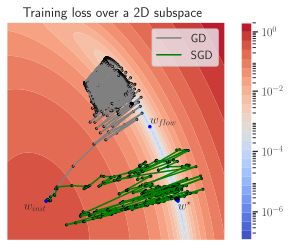

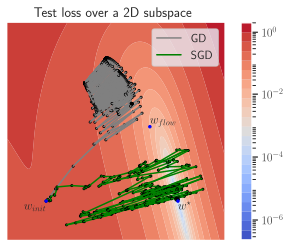

In [11]:
# 2D loss surface visualization

# plt.style.use('seaborn-white')
plot_trajectory = True
fontsize_title, fontsize_axes = 14, 13
log_base = 2  # 1.1

# u_gf, v_gf = us_gf[-1], vs_gf[-1]

n_pts = 100
coef_min, coef_max = -0.5, 2.3
# coef_min, coef_max = -4, 4
alphas = np.linspace(coef_min, coef_max, n_pts)
betas = np.linspace(coef_min, coef_max, n_pts)
test_loss_interpolations = np.zeros((n_pts, n_pts))
train_loss_interpolations = np.zeros((n_pts, n_pts))
u0, v0 = 0.1 * np.ones(d), 0.0 * np.ones(d)
u1, v1 = theta_star**0.5, theta_star**0.5
w1_norm = (np.sum((u1 - u0)**2) + np.sum((v1 - v0)**2))**0.5
u1, v1 = (u1 - u0) / w1_norm, (v1 - v0) / w1_norm
proj_coef = (u_gf - u0) @ u1 + (v_gf - v0) @ v1
u2, v2 = (u_gf - u0) - proj_coef * u1, (v_gf - v0) - proj_coef * v1
w2_norm = (np.sum(u2**2) + np.sum(v2**2))**0.5
u2, v2 = u2 / w2_norm, v2 / w2_norm
for i, alpha in enumerate(alphas):
    for j, beta in enumerate(betas):
        u = u0 + alpha * u1 + beta * u2
        v = v0 + alpha * v1 + beta * v2
        # i and j are swapped to match the logical order of alphas and betas
        test_loss_interpolations[j, i] = loss(X_test, X_test @ (u * v), y_test)
        train_loss_interpolations[j, i] = loss(X, X @ (u * v), y)
max_allowed_val = 100
test_loss_interpolations[test_loss_interpolations > max_allowed_val] = max_allowed_val
train_loss_interpolations[train_loss_interpolations > max_allowed_val] = max_allowed_val


fig = plt.figure()
contours = plt.contourf(alphas, betas, train_loss_interpolations, cmap='coolwarm', locator=ticker.LogLocator(base=log_base, numticks=30))

if plot_trajectory:
    alpha_prev, beta_prev = project(us_gd[0], vs_gd[0], u0, v0, u1, v1, u2, v2)
    for i, (u, v) in enumerate(zip(us_gd, vs_gd)):
        alpha, beta = project(u, v, u0, v0, u1, v1, u2, v2)
        plt.plot((alpha_prev, alpha), (beta_prev, beta), color='gray', label='GD' if i == 0 else '')
        plt.plot(alpha, beta, marker=".", markersize=4.0, color='black')
        alpha_prev, beta_prev = alpha, beta

    alpha_prev, beta_prev = project(us_sgd[0], vs_sgd[0], u0, v0, u1, v1, u2, v2)
    for i, (u, v) in enumerate(zip(us_sgd, vs_sgd)):
        alpha, beta = project(u, v, u0, v0, u1, v1, u2, v2)
        plt.plot((alpha_prev, alpha), (beta_prev, beta), color='green', label='SGD' if i == 0 else '')
        plt.plot(alpha, beta, marker=".", markersize=4.0, color='black')
        alpha_prev, beta_prev = alpha, beta

plt.plot(0, 0, marker=".", markersize=5.0, color='blue')
plt.annotate('$w_{init}$', (0, 0), fontsize=12, horizontalalignment='right', verticalalignment='top')
alpha_erm, beta_erm = project(u_gf, v_gf, u0, v0, u1, v1, u2, v2)
plt.plot(alpha_erm, beta_erm, marker=".", markersize=5.0, color='blue')
plt.annotate('$w_{flow}$', (alpha_erm, beta_erm), fontsize=12, horizontalalignment='left', verticalalignment='bottom')
alpha_star, beta_star = project(theta_star**0.5, theta_star**0.5, u0, v0, u1, v1, u2, v2)
plt.plot(alpha_star, beta_star, marker=".", markersize=5.0, color='blue')
plt.annotate('$w^\star$', (alpha_star, beta_star), fontsize=12, horizontalalignment='left', verticalalignment='top')

cbar = plt.colorbar()
cbar.set_ticks([10**-6, 10**-4, 10**-2, 10**0])
plt.gca().set_aspect("equal")
plt.axis('off')
# plt.xlabel('First direction', fontsize=fontsize_axes)
# plt.ylabel('Second direction', fontsize=fontsize_axes)
plt.title('Training loss over a 2D subspace', fontsize=fontsize_title)
plt.legend()
plt.savefig("plots/loss_surfaces_diag_net_2d_train.pdf", bbox_inches='tight')
plt.show()


fig = plt.figure()
contours = plt.contourf(alphas, betas, test_loss_interpolations, cmap='coolwarm', locator=ticker.LogLocator(base=log_base, numticks=30))

if plot_trajectory:
    alpha_prev, beta_prev = project(us_gd[0], vs_gd[0], u0, v0, u1, v1, u2, v2)
    for i, (u, v) in enumerate(zip(us_gd, vs_gd)):
        alpha, beta = project(u, v, u0, v0, u1, v1, u2, v2)
        plt.plot((alpha_prev, alpha), (beta_prev, beta), color='gray', label='GD' if i == 0 else '')
        plt.plot(alpha, beta, marker=".", markersize=4.0, color='black')
        alpha_prev, beta_prev = alpha, beta

    alpha_prev, beta_prev = project(us_sgd[0], vs_sgd[0], u0, v0, u1, v1, u2, v2)
    for i, (u, v) in enumerate(zip(us_sgd, vs_sgd)):
        alpha, beta = project(u, v, u0, v0, u1, v1, u2, v2)
        plt.plot((alpha_prev, alpha), (beta_prev, beta), color='green', label='SGD' if i == 0 else '')
        plt.plot(alpha, beta, marker=".", markersize=4.0, color='black')
        alpha_prev, beta_prev = alpha, beta

plt.plot(0, 0, marker=".", markersize=5.0, color='blue')
plt.annotate('$w_{init}$', (0, 0), fontsize=12, horizontalalignment='right', verticalalignment='top')
alpha_erm, beta_erm = project(u_gf, v_gf, u0, v0, u1, v1, u2, v2)
plt.plot(alpha_erm, beta_erm, marker=".", markersize=5.0, color='blue')
plt.annotate('$w_{flow}$', (alpha_erm, beta_erm), fontsize=12, horizontalalignment='left', verticalalignment='bottom')
alpha_star, beta_star = project(theta_star**0.5, theta_star**0.5, u0, v0, u1, v1, u2, v2)
plt.plot(alpha_star, beta_star, marker=".", markersize=5.0, color='blue')
plt.annotate('$w^\star$', (alpha_star, beta_star), fontsize=12, horizontalalignment='left', verticalalignment='top')

cbar = plt.colorbar()
cbar.set_ticks([10**-6, 10**-4, 10**-2, 10**0])
plt.gca().set_aspect("equal")
plt.axis('off')
# plt.xlabel('First direction', fontsize=fontsize_axes)
# plt.ylabel('Second direction', fontsize=fontsize_axes)
plt.title('Test loss over a 2D subspace', fontsize=fontsize_title)
plt.legend()
plt.savefig("plots/loss_surfaces_diag_net_2d_test.pdf", bbox_inches='tight')
plt.show()

In [31]:
# Gradient flow
gamma_gf = 0.25
u0, v0 = 0.1 * np.ones(d), 0.0 * np.ones(d)
train_losses_gf, test_losses_gf = [], []
u, v = u0, v0
us_gf, vs_gf = [u], [v]
for i in range(num_iter):
    y_hat = X @ (u * v)
    Xerr = X.T@(y_hat - y)
    grad_u, grad_v = (Xerr * v) / n, (Xerr * u) / n
    
    u = u - gamma_gf * grad_u  # gradient step
    v = v - gamma_gf * grad_v  # gradient step

    if i in iters_loss:
        us_gf.append(u)
        vs_gf.append(v)
        train_losses_gf += [loss(X, X @ (u * v), y)]
        test_losses_gf += [loss(X_test, X_test @ (u * v), y_test)]
u_gf, v_gf = us_gf[-1], vs_gf[-1]
print('GF (gamma={:.3f}): train loss {}, test loss {}'.format(gamma_gf, train_losses_gf[-1], test_losses_gf[-1]))


# SGD with large step sizes and decay
np.random.seed(3)
gamma = 0.03 * 20
train_losses_sgd, test_losses_sgd = [], []
u, v = u0, v0
us_sgd, vs_sgd = [u], [v]
for i in range(num_iter):
    i_t = np.random.randint(n)
    error = X[i_t]@(u*v) - y[i_t] 
    Xerr = error * X[i_t]
    grad_u, grad_v = Xerr * v ,  Xerr * u
    
    u = u - gamma * grad_u   # gradient step
    v = v - gamma * grad_v   # gradient step

    # if i == int(num_iter * 0.003):
    # if i == int(num_iter * 0.01):
    if i == int(num_iter * 0.75):
        gamma /= 1.5

    if i in iters_loss:
        us_sgd.append(np.abs(u))
        vs_sgd.append(np.abs(v))
        train_losses_sgd += [loss(X, X @ (u * v), y)]
        test_losses_sgd += [loss(X_test, X_test @ (u * v), y_test)]
        
print('SGD (gamma={:.3f}): train loss {}, test loss {}'.format(gamma, train_losses_sgd[-1], test_losses_sgd[-1]))



# plt.style.use('seaborn-white')
plot_trajectory = True
fontsize_title, fontsize_axes = 14, 13
log_base = 2  # 1.1

# u_gf, v_gf = us_gf[-1], vs_gf[-1]

n_pts = 100
coef_min, coef_max = -0.4, 2.3
# coef_min, coef_max = -4, 4
alphas = np.linspace(-0.5, 2.3, n_pts)
betas = np.linspace(-0.3, 1.15, n_pts)
test_loss_interpolations = np.zeros((n_pts, n_pts))
train_loss_interpolations = np.zeros((n_pts, n_pts))
u0, v0 = 0.1 * np.ones(d), 0.0 * np.ones(d)
u1, v1 = theta_star**0.5, theta_star**0.5
w1_norm = (np.sum((u1 - u0)**2) + np.sum((v1 - v0)**2))**0.5
u1, v1 = (u1 - u0) / w1_norm, (v1 - v0) / w1_norm
proj_coef = (u_gf - u0) @ u1 + (v_gf - v0) @ v1
u2, v2 = (u_gf - u0) - proj_coef * u1, (v_gf - v0) - proj_coef * v1
w2_norm = (np.sum(u2**2) + np.sum(v2**2))**0.5
u2, v2 = u2 / w2_norm, v2 / w2_norm
for i, alpha in enumerate(alphas):
    for j, beta in enumerate(betas):
        u = u0 + alpha * u1 + beta * u2
        v = v0 + alpha * v1 + beta * v2
        # i and j are swapped to match the logical order of alphas and betas
        test_loss_interpolations[j, i] = loss(X_test, X_test @ (u * v), y_test)
        train_loss_interpolations[j, i] = loss(X, X @ (u * v), y)
max_allowed_val = 100
test_loss_interpolations[test_loss_interpolations > max_allowed_val] = max_allowed_val
train_loss_interpolations[train_loss_interpolations > max_allowed_val] = max_allowed_val


n_first_gf, n_first_sgd = -1, -1
# iter_ids = [1, 5, 15, 25, 50, 75, 100, 150, 200, 300, 400, 500, 520, 540, 567]
iter_ids = range(1, 567)

for n_first_gf, n_first_sgd in zip(iter_ids, iter_ids): 
    fig = plt.figure(figsize=(4.8, 3.8))
    # fig, ax = plt.subplots()
    contours = plt.contourf(alphas, betas, train_loss_interpolations, cmap='coolwarm', locator=ticker.LogLocator(base=log_base, numticks=30))

    if plot_trajectory:
        alpha_prev, beta_prev = project(us_gf[0], vs_gf[0], u0, v0, u1, v1, u2, v2)
        for i, (u, v) in enumerate(zip(us_gf[:n_first_gf], vs_gf[:n_first_gf])):
            alpha, beta = project(u, v, u0, v0, u1, v1, u2, v2)
            plt.plot((alpha_prev, alpha), (beta_prev, beta), color='gray', label='Gradient flow' if i == 0 else '')
            plt.plot(alpha, beta, marker=".", markersize=4.0, color='gray')
            alpha_prev, beta_prev = alpha, beta

        alpha_prev, beta_prev = project(us_sgd[0], vs_sgd[0], u0, v0, u1, v1, u2, v2)
        for i, (u, v) in enumerate(zip(us_sgd[:n_first_sgd], vs_sgd[:n_first_sgd])):
            alpha, beta = project(u, v, u0, v0, u1, v1, u2, v2)
            plt.plot((alpha_prev, alpha), (beta_prev, beta), color='tab:green', label='SGD' if i == 0 else '')
            plt.plot(alpha, beta, marker=".", markersize=4.0, color='black')
            alpha_prev, beta_prev = alpha, beta

    plt.plot(0, 0, marker=".", markersize=5.0, color='blue')
    plt.annotate('$w_{init}$', (0, 0), fontsize=12, horizontalalignment='right', verticalalignment='top')
    alpha_erm, beta_erm = project(u_gf, v_gf, u0, v0, u1, v1, u2, v2)
    plt.plot(alpha_erm, beta_erm, marker=".", markersize=5.0, color='blue')
    plt.annotate('$w_{flow}$', (alpha_erm, beta_erm), fontsize=12, horizontalalignment='left', verticalalignment='bottom')
    alpha_star, beta_star = project(theta_star**0.5, theta_star**0.5, u0, v0, u1, v1, u2, v2)
    plt.plot(alpha_star, beta_star, marker=".", markersize=5.0, color='blue')
    plt.annotate('$w^\star$', (alpha_star, beta_star), fontsize=12, horizontalalignment='left', verticalalignment='top')

    cbar = plt.colorbar()
    cbar.set_ticks([10**-6, 10**-4, 10**-2, 10**0])
    # plt.gca().set_aspect("equal")
    # plt.axis('square')
    plt.axis('off')
    # plt.xlabel('First direction', fontsize=fontsize_axes)
    # plt.ylabel('Second direction', fontsize=fontsize_axes)
    plt.title('Training loss over a 2D subspace', fontsize=fontsize_title)
    plt.legend(loc='upper left')
    plt.savefig("plots/loss_surfaces_{}.png".format(n_first_sgd), bbox_inches='tight', dpi=300)  # dpi=200 already shows up some artifacts (but still ok); dpi=300 is good but ~2x size.
    plt.clf()
    # plt.show()

GF (gamma=0.250): train loss 4.4933977894965735e-10, test loss 0.015398962098749488
SGD (gamma=0.400): train loss 2.0557853545334434e-07, test loss 6.022769528983986e-07


<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

<Figure size 480x380 with 0 Axes>

In [33]:
import imageio
import glob

# images = []
# filenames = sorted(glob.glob('plots/loss_surfaces_*.png'), key=lambda s: int(s.split('_')[-1][:-4]))
# print(filenames)
# for filename in filenames:
#     images.append(imageio.imread(filename))
# imageio.mimsave('plots/twitter.gif', images, duration=1.0)

images = []
filenames = sorted(glob.glob('plots/loss_surfaces_*.png'), key=lambda s: int(s.split('_')[-1][:-4]))
print(filenames)
for filename in filenames:
    images.append(imageio.imread(filename))

w = imageio.get_writer('plots/twitter.mp4', format='FFMPEG', mode='I', fps=20)
for img in images:
    w.append_data(img)
w.close()

['plots/loss_surfaces_1.png', 'plots/loss_surfaces_2.png', 'plots/loss_surfaces_3.png', 'plots/loss_surfaces_4.png', 'plots/loss_surfaces_5.png', 'plots/loss_surfaces_6.png', 'plots/loss_surfaces_7.png', 'plots/loss_surfaces_8.png', 'plots/loss_surfaces_9.png', 'plots/loss_surfaces_10.png', 'plots/loss_surfaces_11.png', 'plots/loss_surfaces_12.png', 'plots/loss_surfaces_13.png', 'plots/loss_surfaces_14.png', 'plots/loss_surfaces_15.png', 'plots/loss_surfaces_16.png', 'plots/loss_surfaces_17.png', 'plots/loss_surfaces_18.png', 'plots/loss_surfaces_19.png', 'plots/loss_surfaces_20.png', 'plots/loss_surfaces_21.png', 'plots/loss_surfaces_22.png', 'plots/loss_surfaces_23.png', 'plots/loss_surfaces_24.png', 'plots/loss_surfaces_25.png', 'plots/loss_surfaces_26.png', 'plots/loss_surfaces_27.png', 'plots/loss_surfaces_28.png', 'plots/loss_surfaces_29.png', 'plots/loss_surfaces_30.png', 'plots/loss_surfaces_31.png', 'plots/loss_surfaces_32.png', 'plots/loss_surfaces_33.png', 'plots/loss_surfac

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1188, 986) to (1200, 992) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
